In [74]:
using Pkg
Pkg.activate("../.")

  Activating project at `~/localProjects/RLProject`


In [278]:
using Plots
using DataFrames
using Statistics
using Interpolations
using LaTeXStrings

using BSON
using Flux
using Flux: loadmodel!

using RLTypes
using NODEDynamics




In [76]:
using Conda
using PyCall

In [78]:
fθ = NODE(4, 32, 3)
fθ = loadmodel!(fθ, BSON.load("../MBRL/pendulum_node_model.bson")[:mE].trained_model[end])

NODE(Chain(Dense(4 => 32)), Chain(Dense(32 => 32, tanh), Dense(32 => 32)), Chain(Dense(32 => 3)))

In [81]:
environment_name = "Pendulum-v1"
gym = pyimport("gymnasium")
env = gym.make(environment_name)

PyObject <TimeLimit<OrderEnforcing<PassiveEnvChecker<PendulumEnv<Pendulum-v1>>>>>

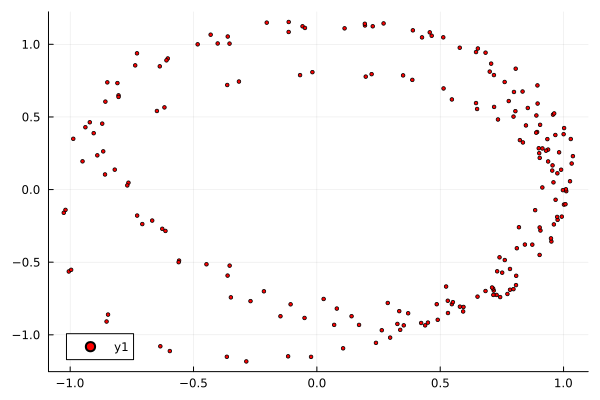

In [179]:
#scatter(theta_next, thetadot_next, mc=:blue, ms=2)
scatter(theta_pred, thetadot_pred, mc=:red, ms=2)

In [87]:
println("Test")

Test


In [334]:
fθ_1 = NODE(4, 32, 3)
fθ_2 = NODE(4, 32, 3)
fθ_3 = NODE(4, 32, 3)
fθ_1 = loadmodel!(fθ_1, BSON.load("../MBRL/pendulum_node_model.bson")[:mE].trained_model[1])
fθ_2 = loadmodel!(fθ_2, BSON.load("../MBRL/pendulum_node_model.bson")[:mE].trained_model[3])
fθ_3 = loadmodel!(fθ_3, BSON.load("../MBRL/pendulum_node_model.bson")[:mE].trained_model[end])


theta_next = []
thetadot_next = []
torque_next = []

theta_pred_1 = []
thetadot_pred_1 = []
torque_pred_1 = []

theta_pred_2 = []
thetadot_pred_2 = []
torque_pred_2 = []

theta_pred_3 = []
thetadot_pred_3 = []
torque_pred_3 = []



state, info = env.reset()

for _ in 1:200

    a = env.action_space.sample()
    next_state, r, term, trunc, _ = env.step(a)
    next_state_pred_1 = fθ_1([1.f0], vcat(state, a))
    next_state_pred_2 = fθ_2([1.f0], vcat(state, a))
    next_state_pred_3 = fθ_3([1.f0], vcat(state, a))

    state = next_state
    
    
    push!(theta_next, next_state[1])
    push!(thetadot_next, next_state[2])
    push!(torque_next, next_state[3])
    
    
    push!(theta_pred_1, next_state_pred_1[1])
    push!(thetadot_pred_1, next_state_pred_1[2])
    push!(torque_pred_1, next_state_pred_1[3])
    
    push!(theta_pred_2, next_state_pred_2[1])
    push!(thetadot_pred_2, next_state_pred_2[2])
    push!(torque_pred_2, next_state_pred_2[3])
    
    push!(theta_pred_3, next_state_pred_3[1])
    push!(thetadot_pred_3, next_state_pred_3[2])
    push!(torque_pred_3, next_state_pred_3[3])

    term | trunc ? break : continue

end

theta_next = convert(Vector{Float64}, theta_next)
thetadot_next = convert(Vector{Float64}, thetadot_next)
torque_next = convert(Vector{Float64}, torque_next);

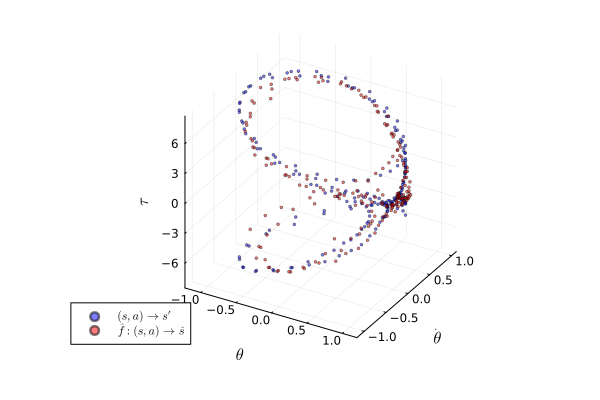

In [335]:
scatter(theta_next, thetadot_next, torque_next, mc=:blue, ms=1.5, ma=0.5, label=L"(s, a) \rightarrow s\prime", xlabel=L"\theta", ylabel=L"\dot{\theta}", zlabel=L"\tau")
scatter!(theta_pred_1, thetadot_pred_1, torque_pred_1, mc=:red, ms=1.5, ma=0.5, label=L"\hat{f}: (s, a) \rightarrow \hat{s}")

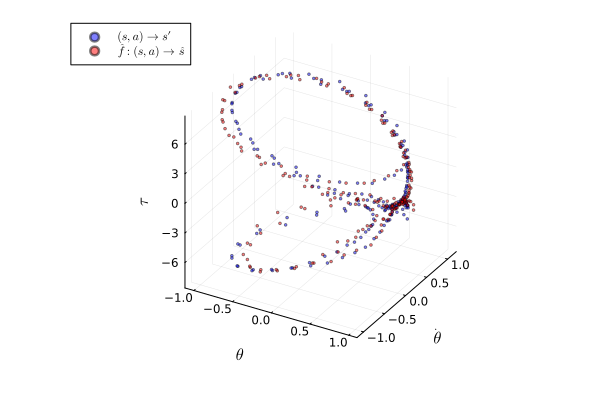

In [336]:
scatter(theta_next, thetadot_next, torque_next, mc=:blue, ma=0.5, ms=1.5, label=L"(s, a) \rightarrow s\prime", xlabel=L"\theta", ylabel=L"\dot{\theta}", zlabel=L"\tau")
scatter!(theta_pred_2, thetadot_pred_2, torque_pred_2, mc=:red, ma=0.5, ms=1.5, label=L"\hat{f}: (s, a) \rightarrow \hat{s}")

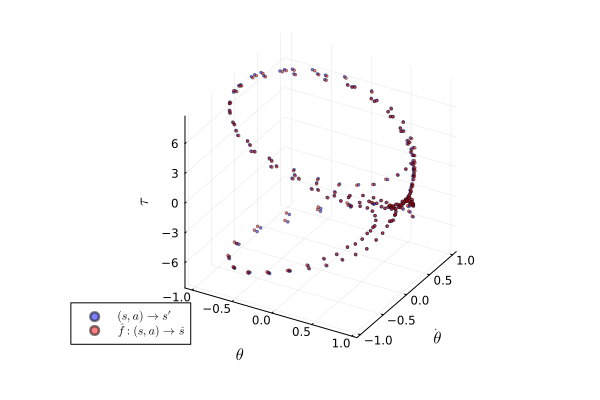

In [337]:
scatter(theta_next, thetadot_next, torque_next, mc=:blue, ma=0.5,ms=1.5, label=L"(s, a) \rightarrow s\prime", xlabel=L"\theta", ylabel=L"\dot{\theta}", zlabel=L"\tau")
scatter!(theta_pred_3, thetadot_pred_3, torque_pred_3, mc=:red, ma=0.5, ms=1.5, label=L"\hat{f}: (s, a) \rightarrow \hat{s}")

In [338]:
#indices = collect(1:length(theta_next))
indices = 1:length(theta_next);

In [339]:
#interp_theta_next = LinearInterpolation(indices, theta_next)
#interp_thetadot_next = LinearInterpolation(indices, thetadot_next)
#interp_torque_next = LinearInterpolation(indices, torque_next)

interp_theta_next = CubicSplineInterpolation(indices, theta_next, bc=Line(OnGrid()))
interp_thetadot_next = CubicSplineInterpolation(indices, thetadot_next, bc=Line(OnGrid()))
interp_torque_next = CubicSplineInterpolation(indices, torque_next, bc=Line(OnGrid()));

In [340]:
fine_indices = LinRange(1, length(theta_next), length(theta_next)*100);

In [341]:
fine_theta_next = interp_theta_next(fine_indices)
fine_thetadot_next = interp_thetadot_next(fine_indices)
fine_torque_next = interp_torque_next(fine_indices);

In [342]:
p1 = plot3d(fine_theta_next, fine_thetadot_next, fine_torque_next, label=L"(s, a) \rightarrow s\prime", xlabel=L"\theta", ylabel=L"\dot{\theta}", zlabel=L"\tau")
p1 = scatter!(theta_pred_1, thetadot_pred_1, torque_pred_1, mc=:red, ms=2, label=L"\hat{f}: (s, a) \rightarrow \hat{s}")

p2 = plot3d(fine_theta_next, fine_thetadot_next, fine_torque_next, label=L"(s, a) \rightarrow s\prime", xlabel=L"\theta", ylabel=L"\dot{\theta}", zlabel=L"\tau")
p2 = scatter!(theta_pred_2, thetadot_pred_2, torque_pred_2, mc=:red, ms=2, label=L"\hat{f}: (s, a) \rightarrow \hat{s}")

p3 = plot3d(fine_theta_next, fine_thetadot_next, fine_torque_next, label=L"(s, a) \rightarrow s\prime", xlabel=L"\theta", ylabel=L"\dot{\theta}", zlabel=L"\tau")
p3 = scatter!(theta_pred_3, thetadot_pred_3, torque_pred_3, mc=:red, ms=2, label=L"\hat{f}: (s, a) \rightarrow \hat{s}");



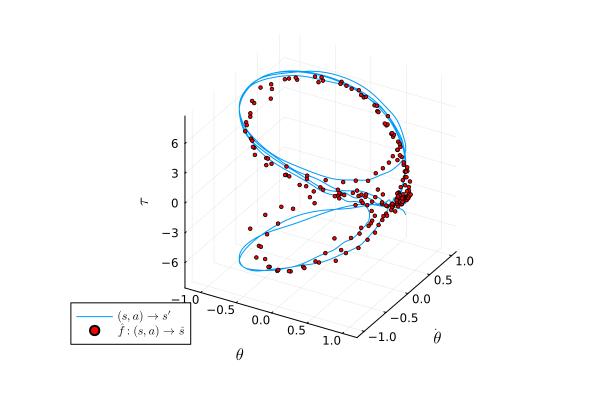

In [343]:
p1

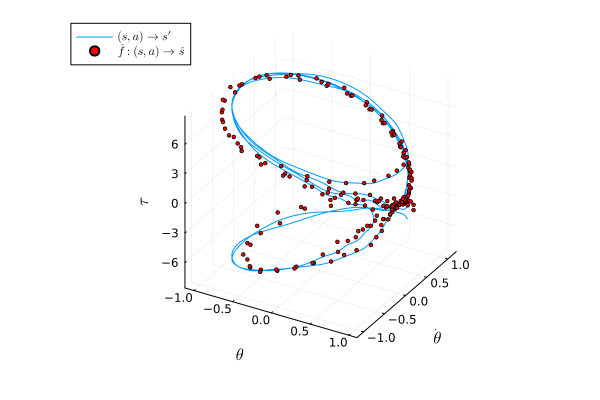

In [344]:
p2

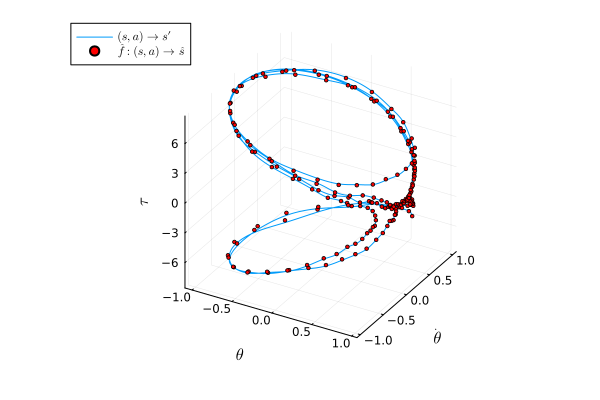

In [345]:
p3